In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import duckdb

# Path to your CSV file
parent_folder = "/home/micha/Documents/run_experiments/Results/rep_615976/"
snake_folder = parent_folder+"Rattlesnake.csv"

# Connect to an in-memory DuckDB database
con = duckdb.connect(database=":memory:")

# Load the CSV into DuckDB
con.execute(f"CREATE TABLE rattlesnake AS SELECT * FROM read_csv_auto('{snake_folder}');")
query = """
SELECT *
FROM rattlesnake
"""

# Execute query and fetch results
df = con.execute(query).fetchdf()
df.head()

# 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Time_Step,Hour,Day,Month,Year,Agent_id,Active,Alive,Behavior,Microhabitat,Body_Temperature,Mass,Metabolic_State,Handling_Time,Attack_Rate,Prey_Density,Prey_Encountered,Prey_Consumed
0,0,0,1,6,2000,3101,False,True,None,None,25.0,316.992339,200.0,0,0.0,0.0,0,0
1,0,0,1,6,2000,3288,False,True,None,None,25.0,128.962721,200.0,0,0.0,0.0,0,0
2,0,0,1,6,2000,3104,False,True,None,None,25.0,376.174854,200.0,0,0.0,0.0,0,0
3,0,0,1,6,2000,3031,False,True,None,None,25.0,256.086191,200.0,0,0.0,0.0,0,0
4,0,0,1,6,2000,3294,False,True,None,None,25.0,183.353341,200.0,0,0.0,0.0,0,0


In [ ]:

# df = pd.read_csv(parent_folder+"Rattlesnake.csv", index_col=None)
# df['datetime'] = df['Hour'].astype(str) + ':' + df['Day'].astype(str) + '/' + df['Month'].astype(str)+ '/' + df['Year'].astype(str)
# print(df[df['Time_Step']==2].head())

     Time_Step  Hour  Day  Month  Year  Agent_id  Active  Alive Behavior  \
600          2     2    1      6  2000      3083    True   True   Forage   
601          2     2    1      6  2000      3187   False   True     Rest   
602          2     2    1      6  2000      3297    True   True   Forage   
603          2     2    1      6  2000      3089    True   True   Forage   
604          2     2    1      6  2000      3213    True   True   Forage   

    Microhabitat  Body_Temperature        Mass  Metabolic_State  \
600         Open         19.172420  240.542902       199.861948   
601       Burrow         22.673792  159.359701       199.911458   
602         Open         22.065684  268.986349       199.795782   
603         Open         22.065684  425.964591       199.775577   
604         Open         21.627278  162.077468       199.887296   

     Handling_Time  Attack_Rate  Prey_Density  Prey_Encountered  \
600              2        0.003         3.765                 0   
601   

In [5]:
# Step 1: Filter for foraging events
forage_df = df[df['Behavior'] == 'Forage'].copy()

# Step 2: Group by Agent and Month, count foraging events
monthly_counts = (
    forage_df.groupby(['Agent_id', 'Day','Month'])
    .size()
    .reset_index(name='Forage_Count')
)


# Step 2: Calculate mean prey encountered and mean prey consumed
mean_prey_stats = (
    forage_df.groupby(['Agent_id', 'Day','Month'])[['Prey_Encountered', 'Prey_Consumed']]
    .mean()
    .reset_index()
    .rename(columns={
        'prey_encountered': 'Mean_Prey_Encountered',
        'prey_consumed': 'Mean_Prey_Consumed'
    })
)

# Step 3: Merge both DataFrames
monthly_summary = pd.merge(monthly_counts, mean_prey_stats, on=['Agent_id', 'Month', 'Day'])
# Display result
print(monthly_summary)


       Agent_id  Day  Month  Forage_Count  Prey_Encountered  Prey_Consumed
0          3001    1      6            11               0.0            0.0
1          3001    1      7             5               0.0            0.0
2          3001    1      8            11               0.0            0.0
3          3001    1      9             7               0.0            0.0
4          3001    2      6             7               0.0            0.0
...         ...  ...    ...           ...               ...            ...
75558      8247   27      7             5               0.0            0.0
75559      8247   28      7             7               0.0            0.0
75560      8247   29      7             7               0.0            0.0
75561      8247   30      7             6               0.0            0.0
75562      8247   31      7            12               0.0            0.0

[75563 rows x 6 columns]


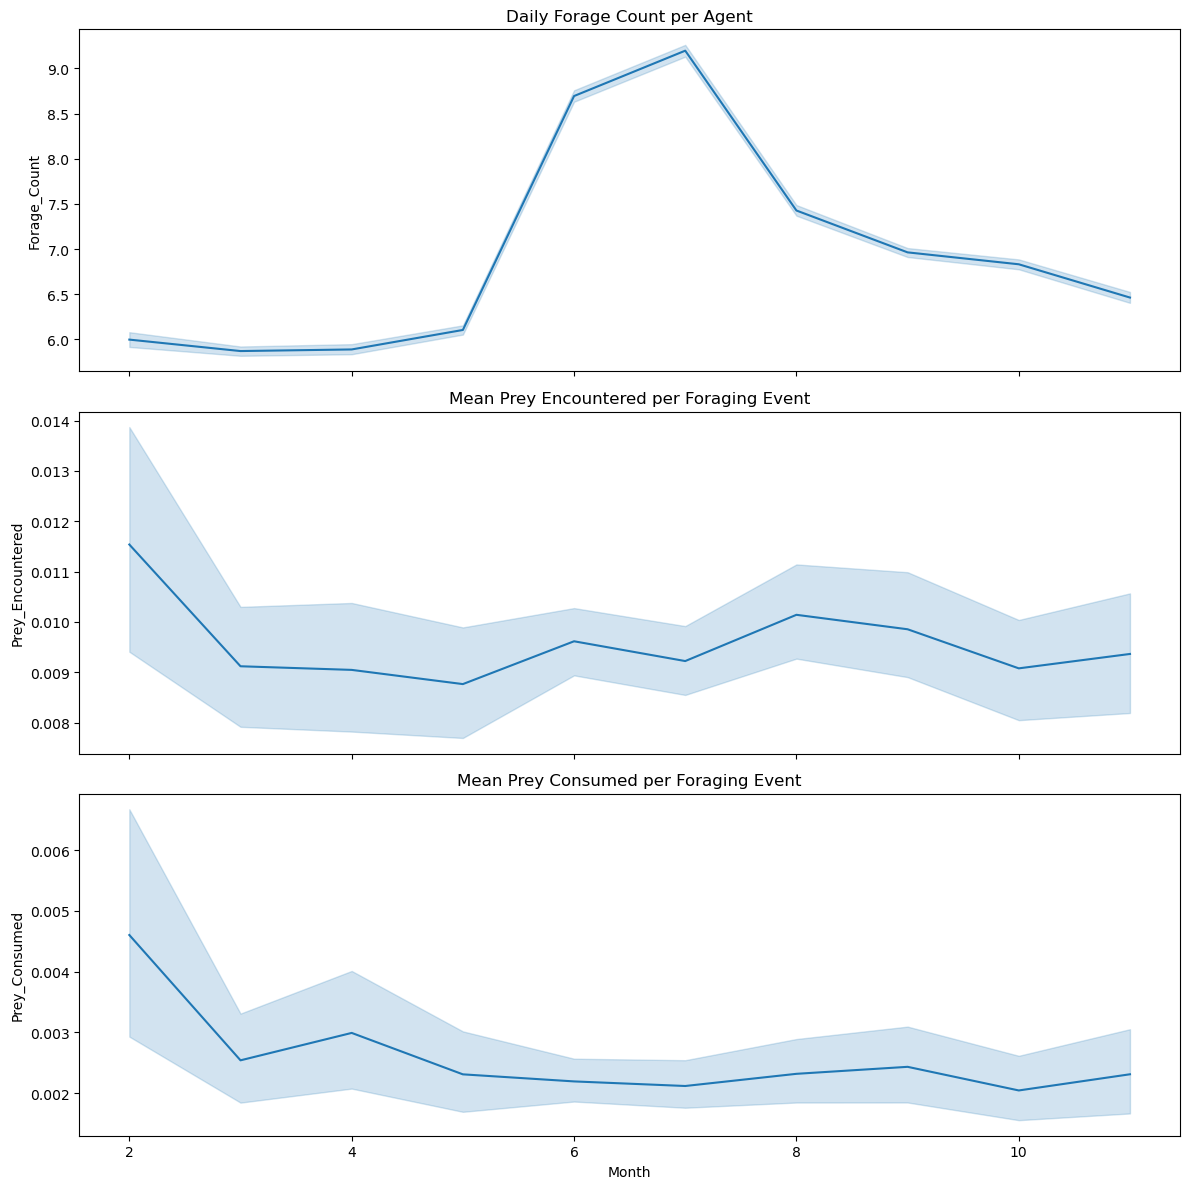

In [6]:
# Set up figure
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot Forage Count
sns.lineplot(data=monthly_summary, x="Month", y="Forage_Count", ax=axs[0])
axs[0].set_title("Daily Forage Count per Agent")

# Plot Prey Encountered
sns.lineplot(data=monthly_summary, x="Month", y="Prey_Encountered", ax=axs[1])
axs[1].set_title("Mean Prey Encountered per Foraging Event")

# Plot Prey Consumed
sns.lineplot(data=monthly_summary, x="Month", y="Prey_Consumed", ax=axs[2])
axs[2].set_title("Mean Prey Consumed per Foraging Event")

plt.tight_layout()
plt.show()

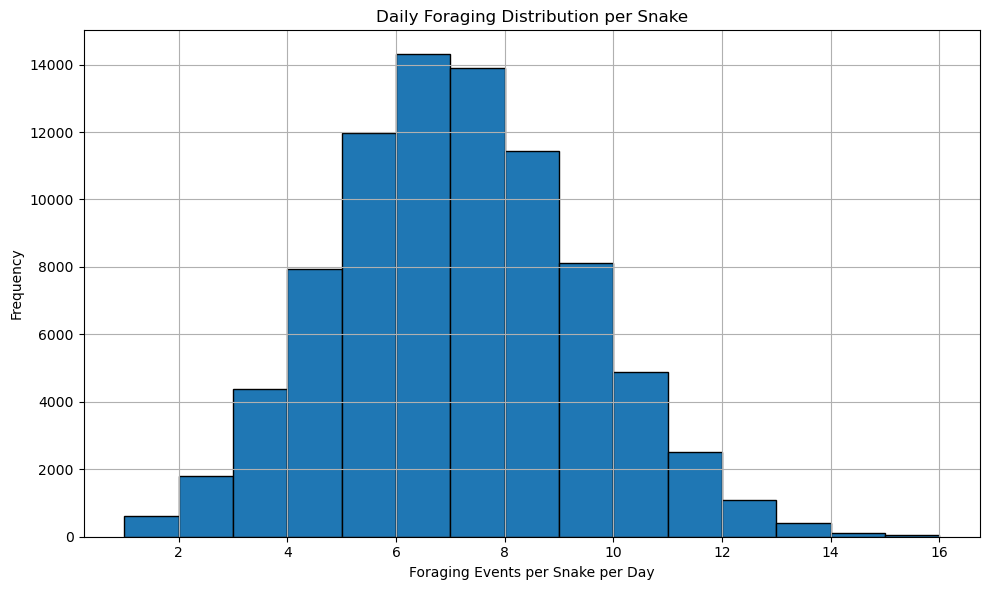

In [7]:
# Create daily timestamps
forage_df['Date'] = pd.to_datetime(dict(
    year=forage_df['Year'],
    month=forage_df['Month'],
    day=forage_df['Day']
))

# Count number of foraging events per snake per day
daily_counts = (
    forage_df.groupby(['Agent_id', 'Date'])
    .size()
    .reset_index(name='Daily_Forage_Count')
)

# Plot histogram of daily foraging behavior
plt.figure(figsize=(10, 6))
plt.hist(daily_counts['Daily_Forage_Count'], bins=15, edgecolor='black')
plt.xlabel('Foraging Events per Snake per Day')
plt.ylabel('Frequency')
plt.title('Daily Foraging Distribution per Snake')
plt.grid(True)
plt.tight_layout()
plt.show()

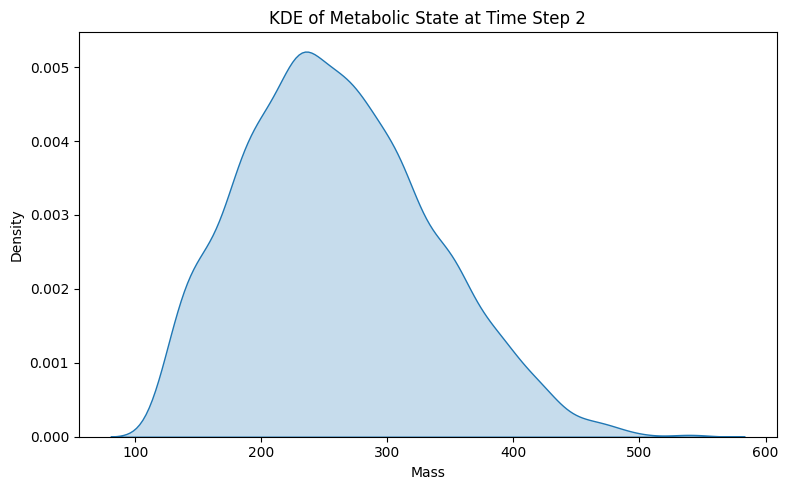

In [6]:

plt.figure(figsize=(8, 5))
sns.kdeplot(data=df[df['Time_Step'] == 30000], x='Mass', fill=True, bw_adjust=0.8)
plt.title('KDE of Metabolic State at Time Step 2')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [19]:
df['Time_Step'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [19]:
print(df.head())

   Time_Step  Hour  Day  Month  Year  Agent_id  Active  Alive Behavior  \
0          0     0    1      6  2000       586   False   True      NaN   
1          0     0    1      6  2000       559   False   True      NaN   
2          0     0    1      6  2000       582   False   True      NaN   
3          0     0    1      6  2000       560   False   True      NaN   
4          0     0    1      6  2000       558   False   True      NaN   

  Microhabitat  Body_Temperature        Mass  Metabolic_State  Handling_Time  \
0          NaN              25.0  356.994810       208.751733              0   
1          NaN              25.0  254.282113        62.334731              0   
2          NaN              25.0  376.706913       315.107933              0   
3          NaN              25.0  286.971254       246.358977              0   
4          NaN              25.0  232.365730        81.305558              0   

   Attack_Rate  Prey_Density  Prey_Encountered  Prey_Consumed    datetime 

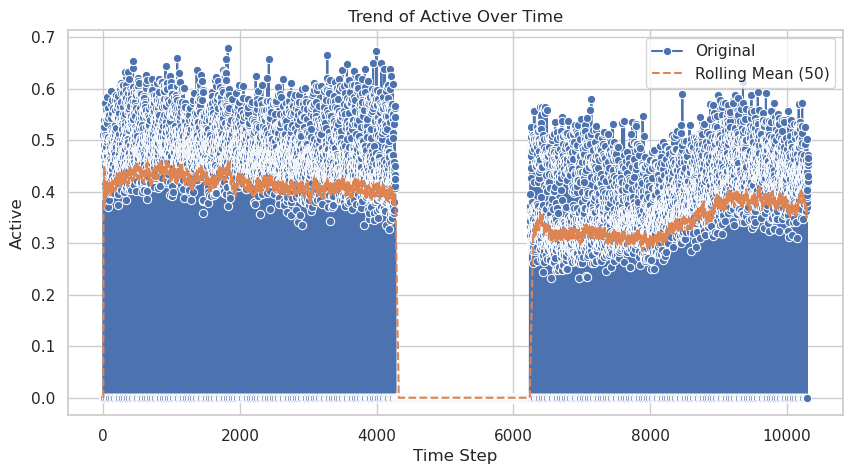

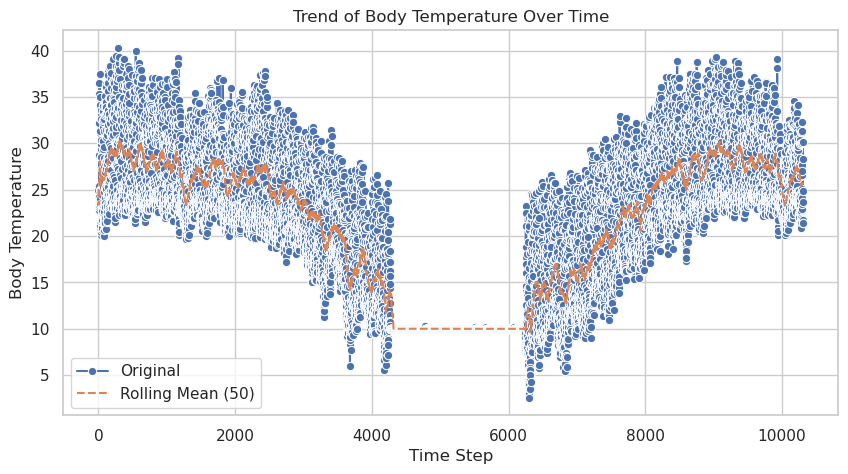

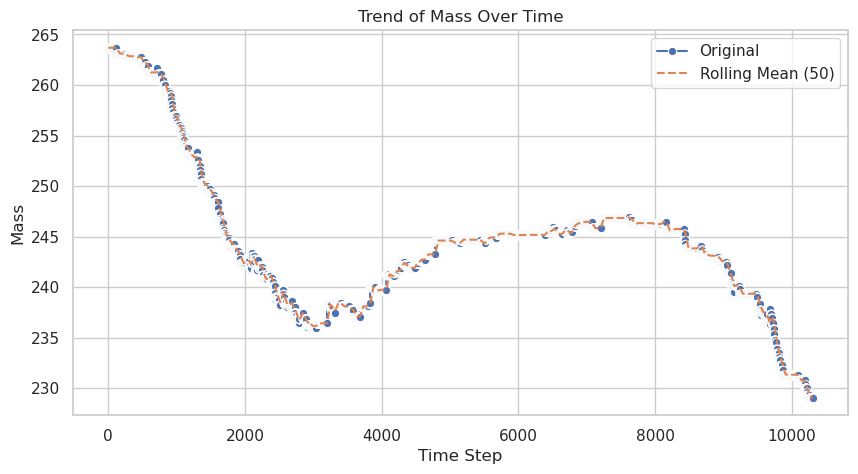

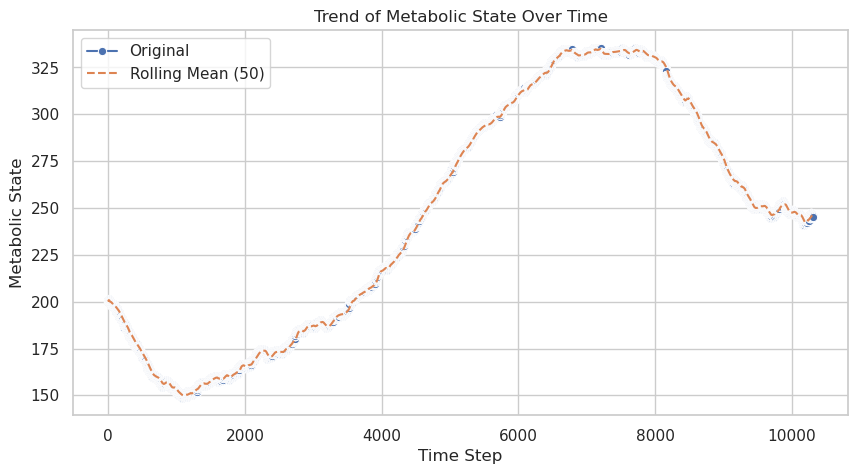

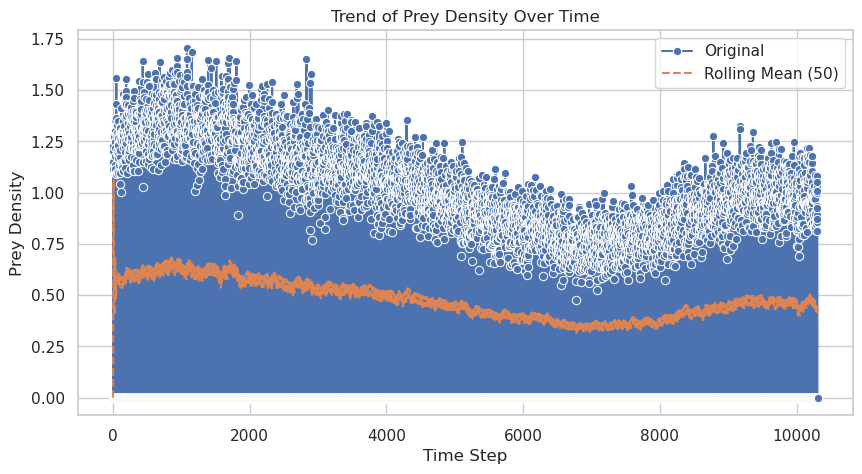

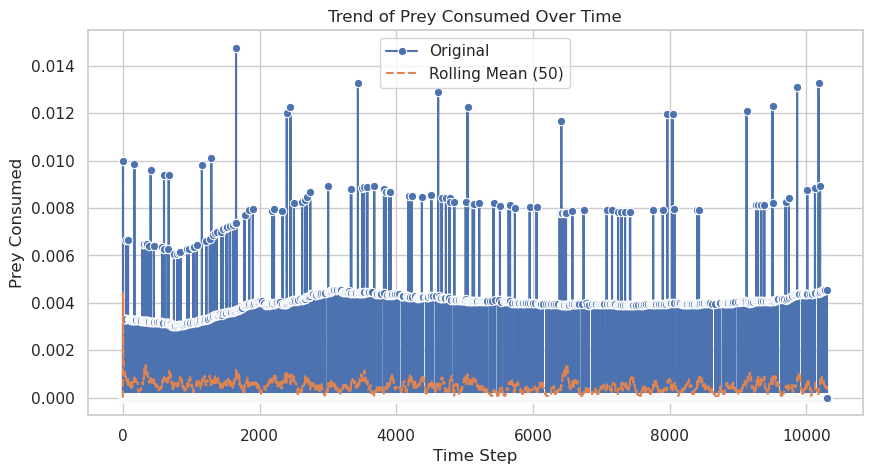

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns before grouping
numeric_columns = ["Active", "Body_Temperature", "Mass", "Metabolic_State", "Prey_Density", "Prey_Consumed"]

grouped_df = df.groupby("Time_Step")[numeric_columns].mean()

# Compute rolling mean with a window size of 5 (adjust as needed)
rolling_window = 50
rolling_df = grouped_df.rolling(window=rolling_window, min_periods=1).mean()

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Plot each variable
for var in numeric_columns:
    plt.figure(figsize=(10, 5))
    
    # Plot original data
    sns.lineplot(data=grouped_df, x=grouped_df.index, y=var, marker="o", label="Original")
    
    # Plot rolling mean
    sns.lineplot(data=rolling_df, x=rolling_df.index, y=var, marker="", linestyle="dashed", label=f"Rolling Mean ({rolling_window})")
    
    plt.xlabel("Time Step")
    plt.ylabel(var.replace("_", " "))
    plt.title(f"Trend of {var.replace('_', ' ')} Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()



In [9]:
df_pop = pd.read_csv(parent_folder+"/Model.csv")
df_pop.head()

,Time_Step,Hour,Day,Month,Year,Rattlesnakes,Krats,Rattlesnakes_Density,Krats_Density,Rattlesnakes_Active,Krats_Active,seed,sim_id
0,0,0,1,6,2000,300,3000,0.75,7.50,0,0,758618.0,615976.0
1,1,1,1,6,2000,300,2999,0.75,7.50,158,1490,NaN,NaN
2,2,2,1,6,2000,300,2996,0.75,7.49,153,1449,NaN,NaN
3,3,3,1,6,2000,300,2995,0.75,7.49,134,1477,NaN,NaN
4,4,4,1,6,2000,300,2994,0.75,7.49,147,1499,NaN,NaN


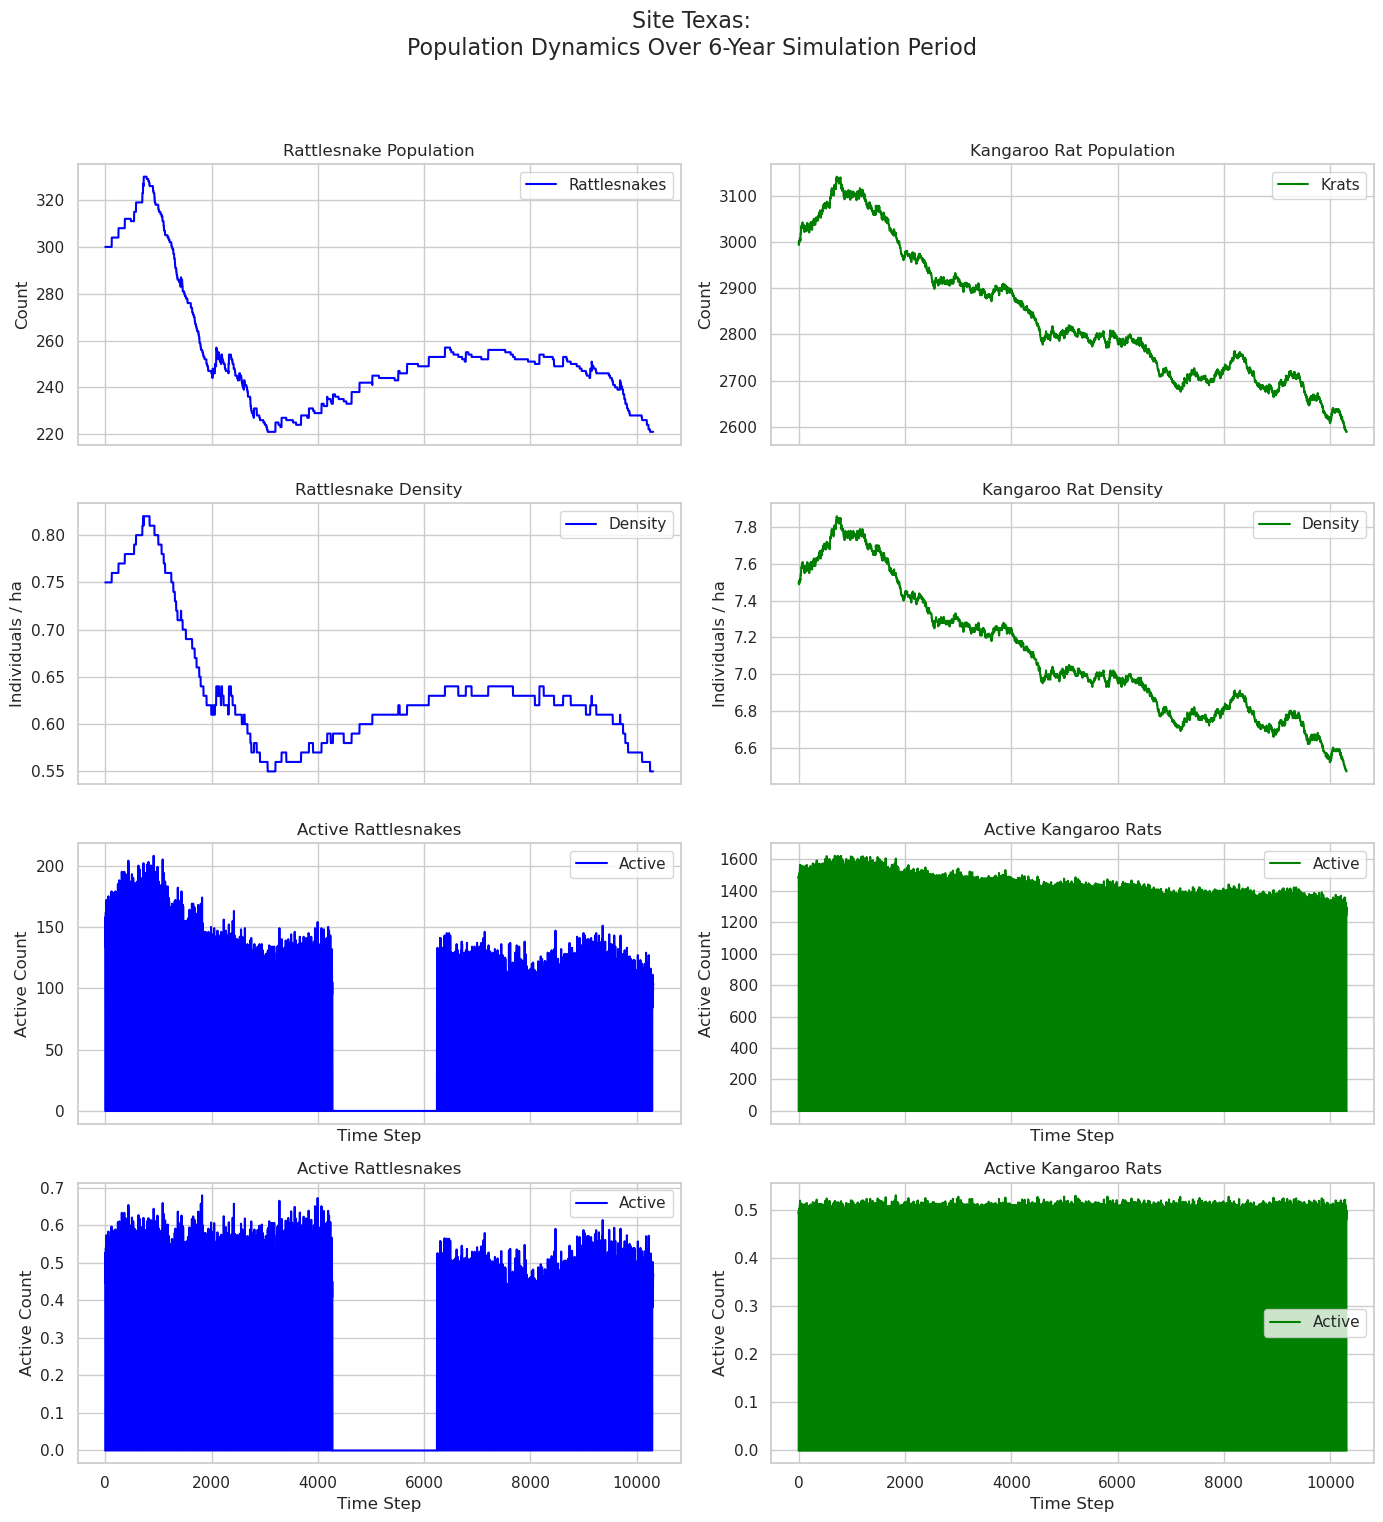

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True)

site_label = "Texas"
suptitle = f"Site {site_label}:\nPopulation Dynamics Over 6-Year Simulation Period"
fig.suptitle(suptitle, fontsize=16)

# Plot 1: Rattlesnake population
axes[0, 0].plot(df_pop["Time_Step"], df_pop["Rattlesnakes"], color="blue", label="Rattlesnakes")
axes[0, 0].set_title("Rattlesnake Population")
axes[0, 0].set_ylabel("Count")
axes[0, 0].legend()

# Plot 2: Krat population
axes[0, 1].plot(df_pop["Time_Step"], df_pop["Krats"], color="green", label="Krats")
axes[0, 1].set_title("Kangaroo Rat Population")
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend()

# Plot 3: Rattlesnake density
axes[1, 0].plot(df_pop["Time_Step"], df_pop["Rattlesnakes_Density"], color="blue", label="Density")
axes[1, 0].set_title("Rattlesnake Density")
axes[1, 0].set_ylabel("Individuals / ha")
axes[1, 0].legend()

# Plot 4: Krat density
axes[1, 1].plot(df_pop["Time_Step"], df_pop["Krats_Density"], color="green", label="Density")
axes[1, 1].set_title("Kangaroo Rat Density")
axes[1, 1].set_ylabel("Individuals / ha")
axes[1, 1].legend()
#axes[1, 1].set_ylim(0, 14)  # Set specific y-limits if needed

# Plot 5: Active rattlesnakes
axes[2, 0].plot(df_pop["Time_Step"], df_pop["Rattlesnakes_Active"], color="blue", label="Active")
axes[2, 0].set_title("Active Rattlesnakes")
axes[2, 0].set_xlabel("Time Step")
axes[2, 0].set_ylabel("Active Count")
axes[2, 0].legend()

# Plot 6: Active krats
axes[2, 1].plot(df_pop["Time_Step"], df_pop["Krats_Active"], color="green", label="Active")
axes[2, 1].set_title("Active Kangaroo Rats")
axes[2, 1].set_xlabel("Time Step")
axes[2, 1].set_ylabel("Active Count")
axes[2, 1].legend()

prop_active_snakes = df_pop["Rattlesnakes_Active"] / df_pop["Rattlesnakes"]
axes[3, 0].plot(df_pop["Time_Step"], prop_active_snakes, color="blue", label="Active")
axes[3, 0].set_title("Active Rattlesnakes")
axes[3, 0].set_xlabel("Time Step")
axes[3, 0].set_ylabel("Active Count")
axes[3, 0].legend()

prop_active_krats = df_pop["Krats_Active"] / df_pop["Krats"]
axes[3, 1].plot(df_pop["Time_Step"], prop_active_krats, color="green", label="Active")
axes[3, 1].set_title("Active Kangaroo Rats")
axes[3, 1].set_xlabel("Time Step")
axes[3, 1].set_ylabel("Active Count")
axes[3, 1].legend()

# Layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()


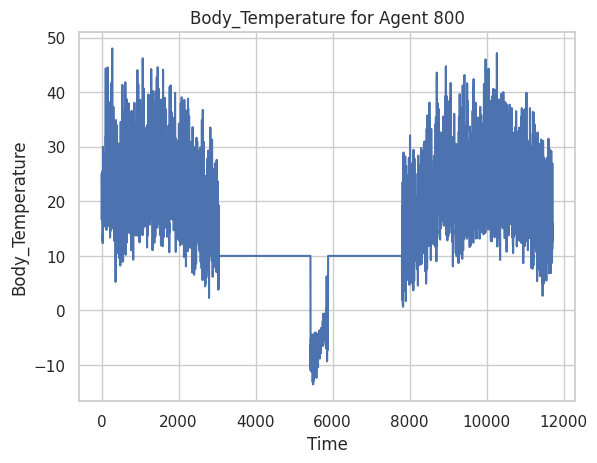

In [24]:
## Single snake
# Filter for the agent with ID 800
single_snake = df[df["Agent_id"] == 2001]

# Extract columns as Numpy arrays
time = single_snake["Time_Step"]
values = single_snake["Body_Temperature"]

# Plot using Matplotlib
plt.plot(time, values)
plt.xlabel("Time")
plt.ylabel("Body_Temperature")
plt.title("Body_Temperature for Agent 800")
plt.show()


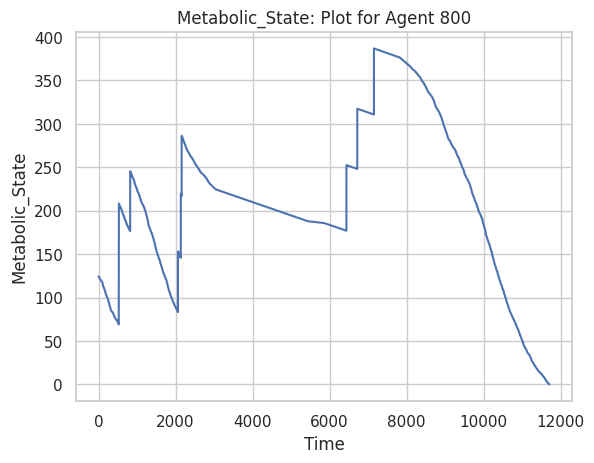

In [26]:
# Extract columns as Numpy arrays
time = single_snake["Time_Step"].to_numpy()
values = single_snake["Metabolic_State"].to_numpy()

# Plot using Matplotlib
plt.plot(time, values)
plt.xlabel("Time")
plt.ylabel("Metabolic_State")
plt.title("Metabolic_State: Plot for Agent 800")
#plt.xlim(0, 300)  # Zoom in on value range
plt.show()


In [9]:
# # Extract columns as Numpy arrays
# single_snake = single_snake.dropna()
# time = single_snake["Time_Step"]
# values = single_snake["Behavior"]

# # Plot using Matplotlib
# plt.figure(figsize=(14, 6))
# plt.scatter(time, values)
# plt.xlabel("Time")
# plt.ylabel("Behavior")
# plt.title("Behavior: Plot for Agent 800")
# plt.show()

In [23]:
df_pd = df.sort_values(by=["Agent_id", "Time_Step"])

# Now you can proceed with the Pandas approach
import pandas as pd

# Shift the 'Behavior' column within each agent group to get the previous behavior
df_pd['previous_state'] = df_pd.groupby("Agent_id")['Behavior'].shift(1)

# Filter out rows where the previous state is null (i.e., the first time step for each agent)
df_filtered = df_pd[df_pd['previous_state'].notnull()]

# Count transitions
transitions = df_filtered.groupby(["previous_state", "Behavior"]).size().reset_index(name="transition_count")

# Calculate total transitions from each previous state
total_transitions = transitions.groupby("previous_state")["transition_count"].sum().reset_index(name="total_transitions")

# Merge to get transition probabilities
transition_probabilities = transitions.merge(total_transitions, on="previous_state")
transition_probabilities["transition_probability"] = (
    transition_probabilities["transition_count"] / transition_probabilities["total_transitions"]
)

print(transition_probabilities)

    previous_state        Behavior  transition_count  total_transitions  \
0        Brumation       Brumation            398265             398431   
1        Brumation          Forage                 2             398431   
2        Brumation            Rest                89             398431   
3        Brumation  Thermoregulate                75             398431   
4           Forage       Brumation                21              39614   
5           Forage          Forage              9050              39614   
6           Forage            Rest             15223              39614   
7           Forage  Thermoregulate             15320              39614   
8             Rest       Brumation                92             278364   
9             Rest          Forage             15370             278364   
10            Rest            Rest            161271             278364   
11            Rest  Thermoregulate            101631             278364   
12  Thermoregulate       

In [11]:
heatmap_data.head()

NameError: name 'heatmap_data' is not defined

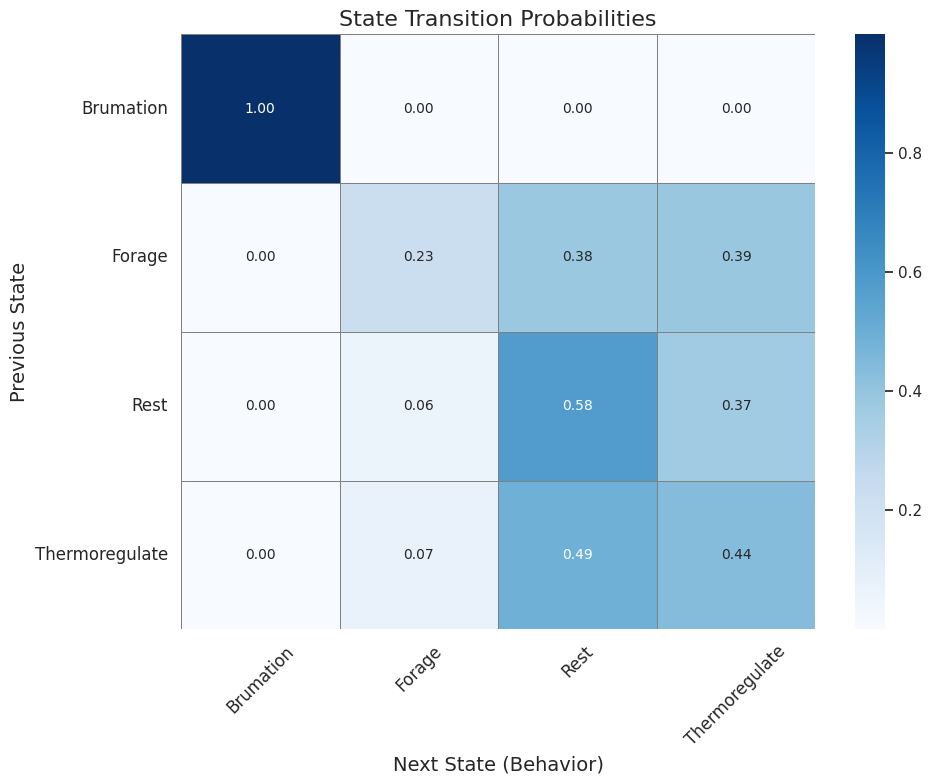

In [24]:
# This could be a good test
import seaborn as sns

heatmap_data = transition_probabilities.pivot(index="previous_state", columns="Behavior", values="transition_probability")

plt.figure(figsize=(10, 8))  # Adjust figure size
sns.heatmap(
    heatmap_data, 
    annot=True,                # Enable annotations
    fmt=".2f",                 # Show values with 3 decimal precision
    cmap="Blues",              # Use a visually clear colormap
    annot_kws={"size": 10},    # Adjust annotation size
    linewidths=0.5,            # Add gridlines
    linecolor="gray"           # Set gridline color
)
plt.title("State Transition Probabilities", fontsize=16)
plt.xlabel("Next State (Behavior)", fontsize=14)
plt.ylabel("Previous State", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=12)   # Keep y-axis labels horizontal
plt.tight_layout()  # Ensure layout is clean
plt.show()

In [9]:
########### Microhabitat
df_pd = df.sort_values(by=["Agent_id", "Time_Step"])

# Now you can proceed with the Pandas approach
import pandas as pd

# Shift the 'Behavior' column within each agent group to get the previous behavior
df_pd['previous_state'] = df_pd.groupby("Agent_id")['Microhabitat'].shift(1)

# Filter out rows where the previous state is null (i.e., the first time step for each agent)
df_filtered = df_pd[df_pd['previous_state'].notnull()]

# Count transitions
transitions = df_filtered.groupby(["previous_state", "Microhabitat"]).size().reset_index(name="transition_count")

# Calculate total transitions from each previous state
total_transitions = transitions.groupby("previous_state")["transition_count"].sum().reset_index(name="total_transitions")

# Merge to get transition probabilities
transition_probabilities = transitions.merge(total_transitions, on="previous_state")
transition_probabilities["transition_probability"] = (
    transition_probabilities["transition_count"] / transition_probabilities["total_transitions"]
)

print(transition_probabilities)

  previous_state   Microhabitat  transition_count  total_transitions  \
0         Burrow         Burrow           8641548            9808674   
1         Burrow           Open           1162356            9808674   
2         Burrow  Winter_Burrow              4770            9808674   
3           Open         Burrow           1161609            1781169   
4           Open           Open            619373            1781169   
5           Open  Winter_Burrow               187            1781169   
6  Winter_Burrow         Burrow              5212           10995344   
7  Winter_Burrow           Open               171           10995344   
8  Winter_Burrow  Winter_Burrow          10989961           10995344   

   transition_probability  
0                0.881011  
1                0.118503  
2                0.000486  
3                0.652161  
4                0.347734  
5                0.000105  
6                0.000474  
7                0.000016  
8                0.999510  

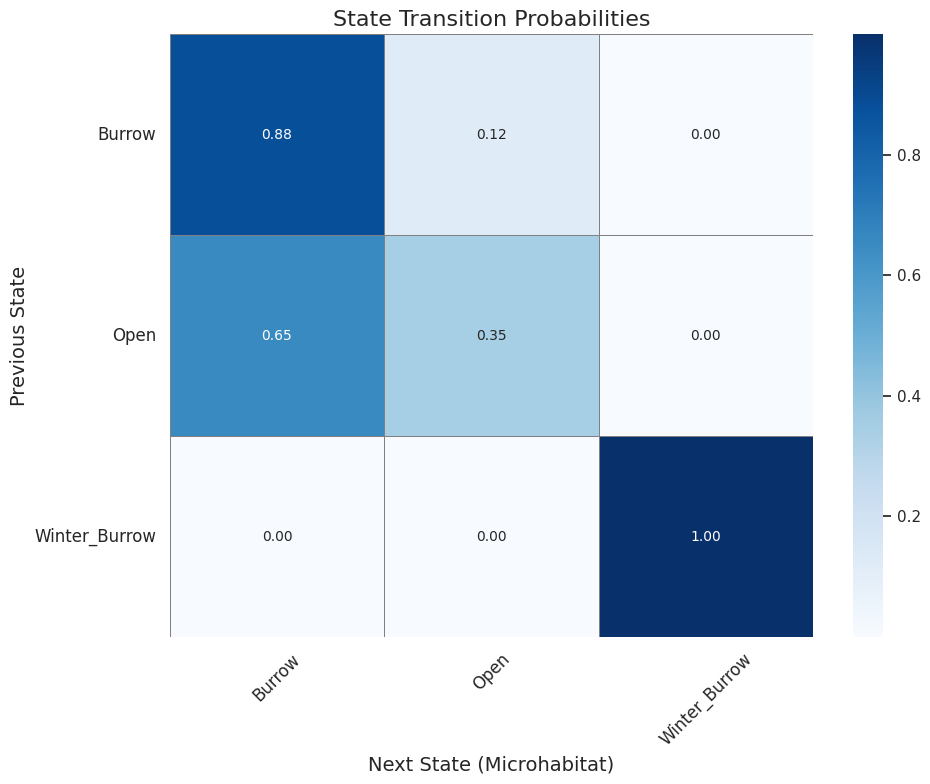

In [10]:
heatmap_data = transition_probabilities.pivot(index="previous_state", columns="Microhabitat", values="transition_probability")

plt.figure(figsize=(10, 8))  # Adjust figure size
sns.heatmap(
    heatmap_data, 
    annot=True,                # Enable annotations
    fmt=".2f",                 # Show values with 3 decimal precision
    cmap="Blues",              # Use a visually clear colormap
    annot_kws={"size": 10},    # Adjust annotation size
    linewidths=0.5,            # Add gridlines
    linecolor="gray"           # Set gridline color
)
plt.title("State Transition Probabilities", fontsize=16)
plt.xlabel("Next State (Microhabitat)", fontsize=14)
plt.ylabel("Previous State", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=12)   # Keep y-axis labels horizohttps://eligurarie.github.io/MovementEcologyBook/questionsinmovementecology.htmlntal
plt.tight_layout()  # Ensure layout is clean
plt.show()